In [1]:
import os
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from itertools import cycle
import seaborn as sns
import statsmodels.api as sm 
from scipy.interpolate import interp1d
from prophet import Prophet

pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
%%time
oj = os.path.join
INPUT_DIR = '../input/m5-forecasting-accuracy/'
train = pd.read_csv(oj(INPUT_DIR, 'trainset.csv'))
price = pd.read_csv(oj(INPUT_DIR, 'sell_prices.csv'))
calendar = pd.read_csv(oj(INPUT_DIR, 'calendar.csv'))

sample_submit = pd.read_csv(oj(INPUT_DIR, 'submit.csv'))

CPU times: total: 2.95 s
Wall time: 8.83 s


In [6]:
print(calendar['event_name_1'].unique())

[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']


In [7]:
print(calendar['event_type_1'].unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']


In [8]:
print(calendar['event_name_2'].unique())

[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [9]:
print(calendar['event_type_2'].unique())

[nan 'Cultural' 'Religious']


In [10]:
print(price.head())
print(price.shape)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
(6841121, 4)


In [26]:
print(train.shape)

(30490, 1933)


C:\Users\sasa4\AppData\Local\Temp\ipykernel_26652\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  1        8.38
1923  2016-05-05  d_1924     11614  1        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  2        8.38
1926  2016-05-08  d_1927     11615  1        8.38

[1927 rows x 5 columns]
-------------------


21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.870011   -0.064421    1.490281     0.870011     0.870011   
1928 2016-05-10  0.870593   -0.069714    1.600720     0.870593     0.870593   
1929 2016-05-11  0.871175   -0.170017    1.459229     0.871175     0.871175   
1930 2016-05-12  0.871758   -0.151227    1.490637     0.871758     0.871758   
1931 2016-05-13  0.872340   -0.109431    1.488859     0.872340     0.872340   
1932 2016-05-14  0.872922    0.000032    1.657664     0.872922     0.872922   
1933 2016-05-15  0.873504   -0.038845    1.480936     0.873504     0.873504   
1934 2016-05-16  0.874086   -0.112172    1.385361     0.874086     0.874086   
1935 2016-05-17  0.874668   -0.166155    1.531865     0.874668     0.874

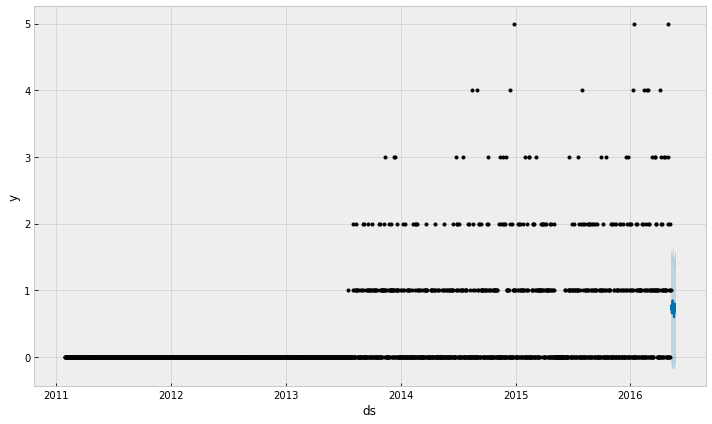

In [3]:
for i in range(train.shape[0]):
    df = pd.DataFrame(calendar[['date', 'd', 'wm_yr_wk']])
    df_train =  df.loc[0:1926]
    df_test = df.loc[1927:]
    #print(df_train)
    #print(df_test)
    df_train['y'] = train.loc[i,'d_1':].values
    df_train = pd.merge(df_train, price[(price['store_id'] == train.loc[i,'store_id']) & (price['item_id'] == train.loc[0,'item_id'])][['wm_yr_wk', 'sell_price']], how='left', on=['wm_yr_wk'])
    df_train = df_train.rename(columns={'date': 'ds'})
    #df_train = df_train.drop(["price"], axis=1)
    print(df_train)
    print("-------------------")

    print("wataru")
    
    model = Prophet()
    model.fit(df_train)
    future = model.make_future_dataframe(periods=14)
    print(future)
    forecast = model.predict(future)
    print(forecast.tail(14))
    model.plot(forecast.tail(14))
    plt.show()
    #df_train.to_csv('df_train' + str(i) + '.csv', index=False)